In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [132]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
from collections import OrderedDict

%matplotlib inline

Download the pretrained model

In [133]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
import random
import torch.nn.functional as F

def random_plot(image):

    n_feature = image.size()[0]
    n_features = random.sample(range(n_feature+1),16)
    fig = plt.figure()
    cols = 4
    rows = 4

    i=1
    for idx in n_features:
        img = image[idx].detach().numpy()
        ax = fig.add_subplot(rows,cols,i)
        ax.imshow(img, cmap ='gray')
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
    
    plt.show()
         
def plot(image):
    n_features = image.size()[0]
    fig = plt.figure() 
    cols = 16
    rows = n_features//cols
    i = 1

    for idx in range(n_features):
        img = image[idx].detach().numpy()
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
    
    plt.show()

def plot_2d(image):
    image = image.detach().numpy()
    plt.imshow(image)
    plt.show()


class ConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts, k, s, p):
        super(ConvBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts, kernel_size=(k, k), stride=(s, s), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.convolution(input_img)
        #random_plot(x)
        return x


class ReduceConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts_1, out_fts_2, k, p):
        super(ReduceConvBlock, self).__init__()
        self.redConv = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts_1, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_fts_1, out_channels=out_fts_2, kernel_size=(k, k), stride=(1, 1), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.redConv(input_img)

        return x


class AuxClassifier(nn.Module):
    def __init__(self, in_fts, num_classes):
        super(AuxClassifier, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(5, 5), stride=(3, 3))
        self.conv = nn.Conv2d(in_channels=in_fts, out_channels=128, kernel_size=(1, 1), stride=(1, 1))
        self.relu = nn.ReLU()
        #change
        #self.fc = nn.Linear(4,1024)
        # input 4x4x128 output 1024
        self.fc = nn.Linear(512,1024)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.7)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.avgpool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.relu(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.classifier(x)
        # N x 1000 (num_classes)

        return x


class InceptionModule(nn.Module):
    def __init__(self, curr_in_fts, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool_proj):
        super(InceptionModule, self).__init__()
        self.conv1 = ConvBlock(curr_in_fts, f_1x1, 1, 1, 0)#conv 1x1+1 -> 64(output)
        self.conv2 = ReduceConvBlock(curr_in_fts, f_3x3_r, f_3x3, 3, 1) # 1x1 -> 96(output) -> 3x3 ->128(output)
        self.conv3 = ReduceConvBlock(curr_in_fts, f_5x5_r, f_5x5, 5, 2) # 1x1 -> 16(output) -> 5x5 -> 32(outputs)

        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=curr_in_fts, out_channels=f_pool_proj, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        ) #

    def forward(self, input_img):
        out1 = self.conv1(input_img)
        out2 = self.conv2(input_img)
        out3 = self.conv3(input_img)
        out4 = self.pool_proj(input_img)

        x = torch.cat([out1, out2, out3, out4], dim=1)

        return x


class MyGoogleNet(nn.Module):
    def __init__(self, in_fts=3, num_class=1000):
        super(MyGoogleNet, self).__init__()
        self.conv1 = ConvBlock(in_fts, 64, 7, 2, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, 1, 1, 0), #### 입력 채널의 크기 == 출력 채녈의 크기 -> 해당 층의 역할??
            ConvBlock(64, 192, 3, 1, 1) #
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.aux_classifier1 = AuxClassifier(512, num_class)
        self.aux_classifier2 = AuxClassifier(528, num_class)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(8, 8))
        #self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1024*8*8,num_class)
            #nn.Linear(1024 * 7 * 7, num_class)
        )

    def forward(self, input_img):
        N = input_img.shape[0]

        #part1
        x = self.conv1(input_img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
      

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool1(x)
        x = self.inception_4a(x)
        out1 = self.aux_classifier1(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        out2 = self.aux_classifier2(x)
        x = self.inception_4e(x)
        x = self.maxpool1(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        if self.training == True:
            return [x, out1, out2]
        else:
            return x



In [134]:
#import torchvision.models as models
#model = models.googlenet(pretrained = True)

model = MyGoogleNet()

Switch device to gpu if available

In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))

Device: Tesla P100-PCIE-16GB


Freeze model's parameters 

In [136]:
for param in model.parameters():
    param.requires_grad = False 

Upgrading model.

In [137]:
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024,512)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(512,2)),
    ('output', nn.LogSoftmax(dim = 1))
    ]))
model #model structure 

MyGoogleNet(
  (conv1): ConvBlock(
    (convolution): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
    )
  )
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): ConvBlock(
      (convolution): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (1): ConvBlock(
      (convolution): Sequential(
        (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
  )
  (inception_3a): InceptionModule(
    (conv1): ConvBlock(
      (convolution): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (conv2): ReduceConvBlock(
      (redConv): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), 

I'm using .ImageFolder() as dataloader for train.

In [138]:
def load_data(data_folder, batch_size, num_workers):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(128),
        transforms.ToTensor()
    ])
    
    data = torchvision.datasets.ImageFolder(root = data_folder, transform = transform)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    return data_loader 

The code i used to prepare data for .ImageFolder() on kaggle, started here...

In [139]:
import zipfile
os.chdir('/kaggle/working/')
file_list = ['/kaggle/input/dogs-vs-cats/train.zip','/kaggle/input/dogs-vs-cats/test1.zip']

for file in file_list:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [140]:
#os.mkdir('/kaggle/working/train/dog')
#os.mkdir('/kaggle/working/train/cat')

In [141]:
import shutil

category = []
filenames = os.listdir('/kaggle/working/train/')
od = '/kaggle/working/train/'
for file in filenames:
    if os.path.isdir(od + file) == False:
        category = file.split('.')[0]
        if category == 'dog':
            shutil.move('/kaggle/working/train/' + file, '/kaggle/working/train/dog/' + file)
        else:
            shutil.move('/kaggle/working/train/' + file, '/kaggle/working/train/cat/' + file)
    else: pass

... and it ended.

Loading train data to the model

In [142]:
data_folder = '/kaggle/working/train/'
batch_size = 32
num_workers = 0
dataloader = load_data(data_folder, batch_size, num_workers)

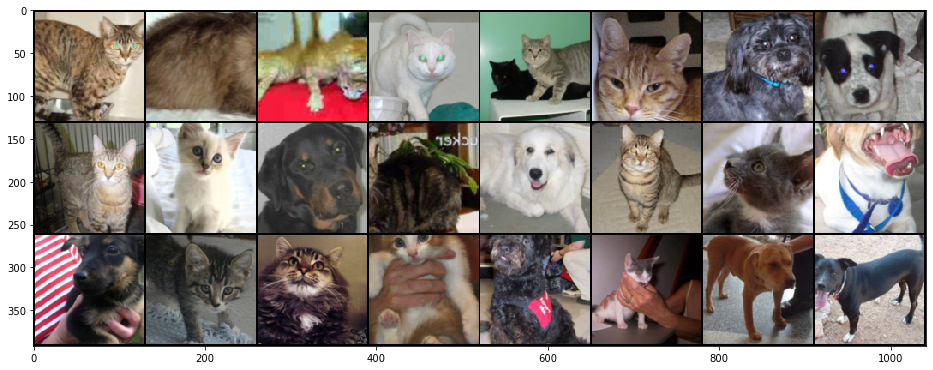

In [143]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [144]:
model = model.to(device) #shifting model to gpu
loss = nn.CrossEntropyLoss()
loss1 = nn.CrossEntropyLoss()
loss2 = nn.CrossEntropyLoss()
discount = 0.3

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

Training the model.

[Epoch 1/3] Iteration 200 -> Train Loss: 11.0491, Accuracy: 0.000
[Epoch 1/3] Iteration 400 -> Train Loss: 11.0493, Accuracy: 0.000
[Epoch 1/3] Iteration 600 -> Train Loss: 11.0488, Accuracy: 0.000
[Epoch 2/3] Iteration 800 -> Train Loss: 11.0491, Accuracy: 0.000
[Epoch 2/3] Iteration 1000 -> Train Loss: 11.0488, Accuracy: 0.000
[Epoch 2/3] Iteration 1200 -> Train Loss: 11.0490, Accuracy: 0.000
[Epoch 2/3] Iteration 1400 -> Train Loss: 11.0489, Accuracy: 0.000
[Epoch 3/3] Iteration 1600 -> Train Loss: 11.0490, Accuracy: 0.000
[Epoch 3/3] Iteration 1800 -> Train Loss: 11.0488, Accuracy: 0.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 11.0488, Accuracy: 0.000
[Epoch 3/3] Iteration 2200 -> Train Loss: 11.0490, Accuracy: 0.000


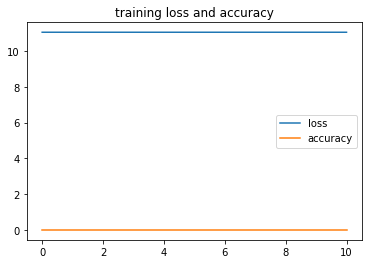

In [145]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        
        for param in model.parameters():
            param.requires_grad = True
        o,o1,o2 = model(samples)
        
        
        #check labels
        loss_value = loss(o,labels) + discount*(loss1(o1,labels) + loss2(o2,labels))
        #loss = criterion(output[0], labels)
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value.item()
        scheduler.step() 
        output = torch.cat([o1, o2, o], dim=1)
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
        
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

Loading test data to the model

In [146]:
PATH = '/kaggle/working/result'
torch.save(model,PATH)

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGoogleNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type InceptionModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ReduceConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/c

In [147]:
test_dir = '/kaggle/working/test1'
test_files = os.listdir(test_dir)

In [148]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [149]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle = False, num_workers=0)

In [150]:
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.head()

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list

Finally testing the model.

In [ ]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

So, I training the model on my laptop at GeForce MX110 with 2 Gb VRAM (not allowed) and bath size 24.  
I had this result:   
> [Epoch 1/3] Iteration 200 -> Train Loss: 0.3037, Accuracy: 0.958  
> [Epoch 1/3] Iteration 400 -> Train Loss: 0.2527, Accuracy: 0.958  
> [Epoch 1/3] Iteration 600 -> Train Loss: 0.2506, Accuracy: 0.917  
> [Epoch 1/3] Iteration 800 -> Train Loss: 0.2286, Accuracy: 0.917  
> [Epoch 1/3] Iteration 1000 -> Train Loss: 0.2193, Accuracy: 0.917  
> [Epoch 2/3] Iteration 1200 -> Train Loss: 0.2300, Accuracy: 0.792  
> [Epoch 2/3] Iteration 1400 -> Train Loss: 0.2057, Accuracy: 0.875  
> [Epoch 2/3] Iteration 1600 -> Train Loss: 0.2116, Accuracy: 1.000  
> [Epoch 2/3] Iteration 1800 -> Train Loss: 0.2023, Accuracy: 0.833  
> [Epoch 2/3] Iteration 2000 -> Train Loss: 0.2072, Accuracy: 0.875  
> [Epoch 3/3] Iteration 2200 -> Train Loss: 0.2073, Accuracy: 0.958  
> [Epoch 3/3] Iteration 2400 -> Train Loss: 0.2093, Accuracy: 0.917  
> [Epoch 3/3] Iteration 2600 -> Train Loss: 0.1987, Accuracy: 0.958  
> [Epoch 3/3] Iteration 2800 -> Train Loss: 0.2049, Accuracy: 0.958  
> [Epoch 3/3] Iteration 3000 -> Train Loss: 0.2007, Accuracy: 0.917  

Interestingly, resnet18 shows slightly better results when on the same hardware:
> [Epoch 1/3] Iteration 200 -> Train Loss: 0.2600, Accuracy: 0.875  
> [Epoch 1/3] Iteration 400 -> Train Loss: 0.2020, Accuracy: 0.958  
> [Epoch 1/3] Iteration 600 -> Train Loss: 0.2050, Accuracy: 0.875  
> [Epoch 1/3] Iteration 800 -> Train Loss: 0.1875, Accuracy: 0.875  
> [Epoch 1/3] Iteration 1000 -> Train Loss: 0.1840, Accuracy: 0.833  
> [Epoch 2/3] Iteration 1200 -> Train Loss: 0.1809, Accuracy: 1.000  
> [Epoch 2/3] Iteration 1400 -> Train Loss: 0.1794, Accuracy: 0.958  
> [Epoch 2/3] Iteration 1600 -> Train Loss: 0.1855, Accuracy: 0.958  
> [Epoch 2/3] Iteration 1800 -> Train Loss: 0.1654, Accuracy: 0.833  
> [Epoch 2/3] Iteration 2000 -> Train Loss: 0.1656, Accuracy: 0.833  
> [Epoch 3/3] Iteration 2200 -> Train Loss: 0.1641, Accuracy: 0.958  
> [Epoch 3/3] Iteration 2400 -> Train Loss: 0.1748, Accuracy: 0.917  
> [Epoch 3/3] Iteration 2600 -> Train Loss: 0.1739, Accuracy: 0.958  
> [Epoch 3/3] Iteration 2800 -> Train Loss: 0.1663, Accuracy: 0.958  
> [Epoch 3/3] Iteration 3000 -> Train Loss: 0.1619, Accuracy: 0.958  